In [1]:
import xarray as xr
from pathlib import Path
import xeofs
import cartopy.crs as ccrs
import emd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import proplot as pplt

In [2]:
cmip6_path = Path('/projects/NS9873K/idso/cmip6/')
cmip6_slp = list(cmip6_path.glob('psl*historical*'))

In [3]:
model = xeofs.single.EOF(n_modes=50, standardize=True, use_coslat=True)

In [5]:
i = 0
print(cmip6_slp[i])
ds = xr.open_dataset(cmip6_slp[i])

/projects/NS9873K/idso/cmip6/psl_Amon_CMCC-CM2-SR5_historical_r1i1p1f1_gn_185001-201412.nc


In [5]:
slp = ds.psl.sel(time=slice('1950','2015')).sel(lat=slice(20,90))

slp_ann = slp.groupby(slp.time.dt.year).mean()

In [6]:
signal_slp = (slp_ann.isel(lat=32,lon=151) - slp_ann.isel(lat=32,lon=151).mean()).values

/projects/NS9873K/owul/conda/envs/ntc_pred/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 65, using nperseg = 65
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


Text(0.5, 0, 'Frequency [1/year]')

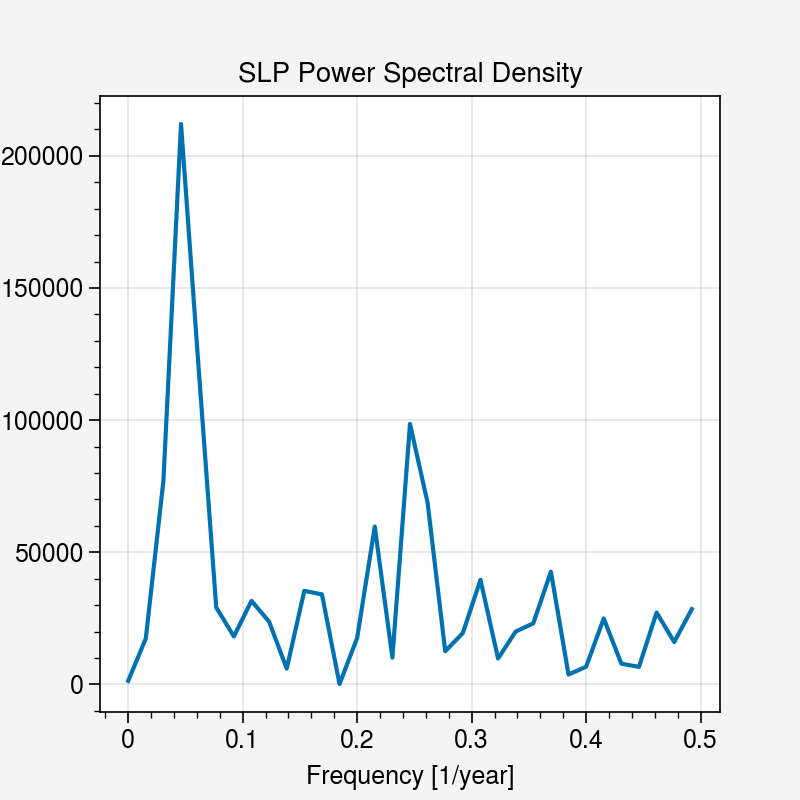

In [7]:
f,pxx = signal.welch(signal_slp)
plt.plot(f,pxx)
plt.title('SLP Power Spectral Density')
plt.xlabel('Frequency [1/year]')

In [8]:
imf = emd.sift.sift(signal_slp, imf_opts={'sd_thresh': 0.1})
# emd.plotting.plot_imfs(imf)

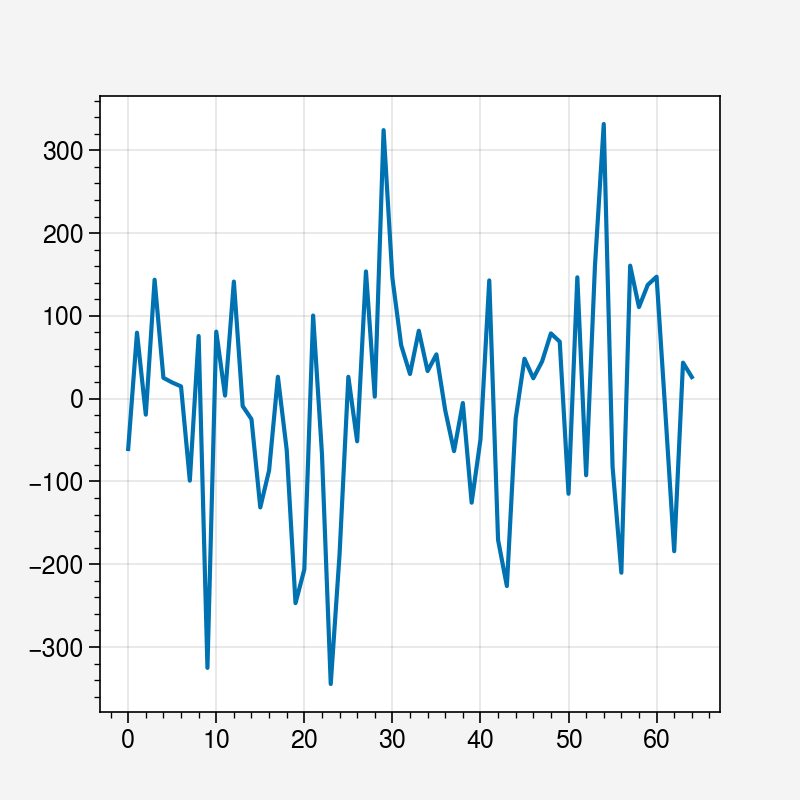

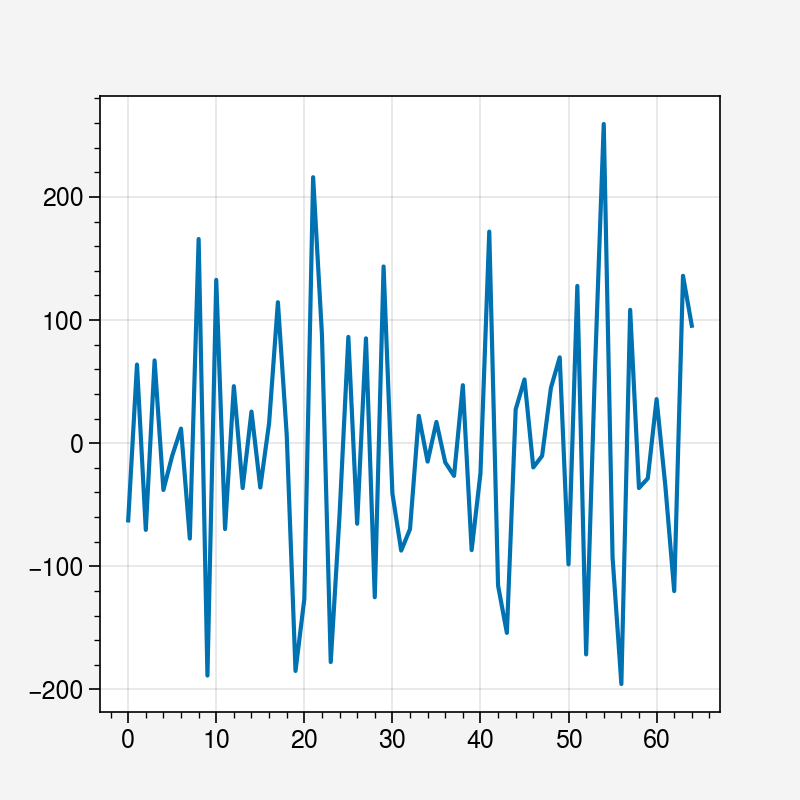

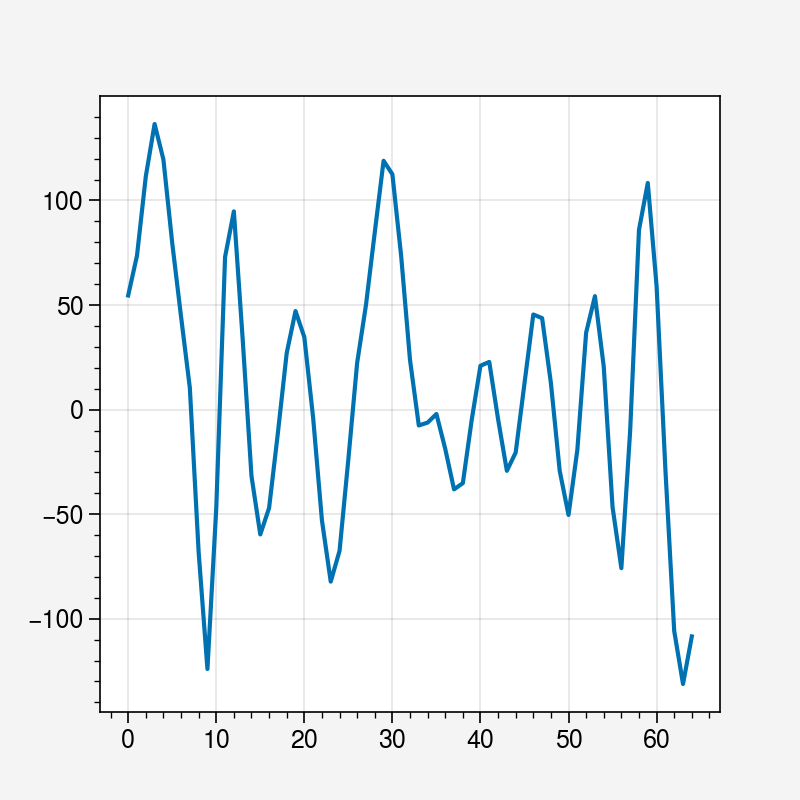

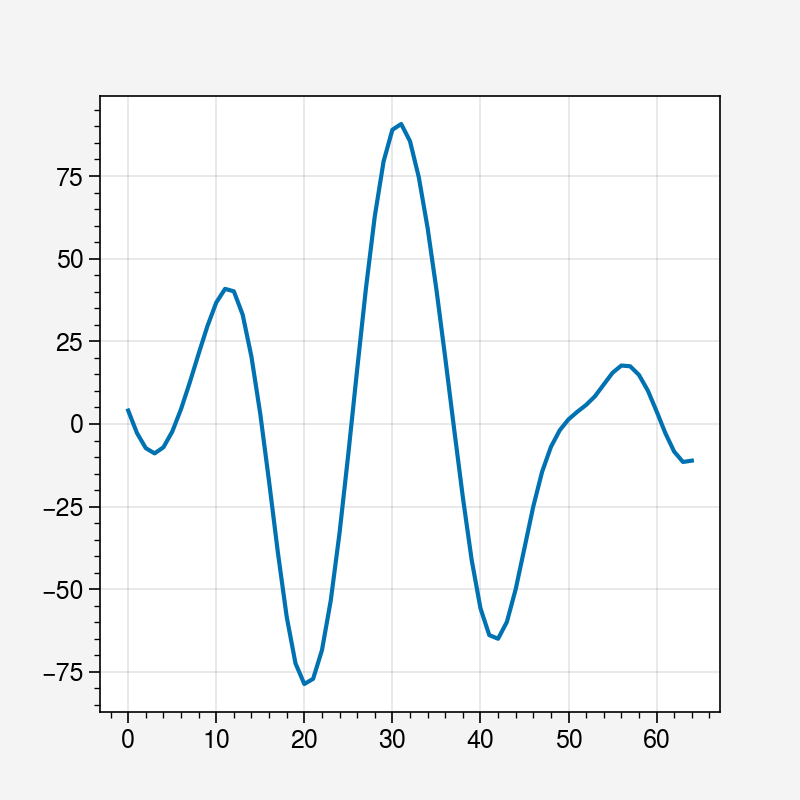

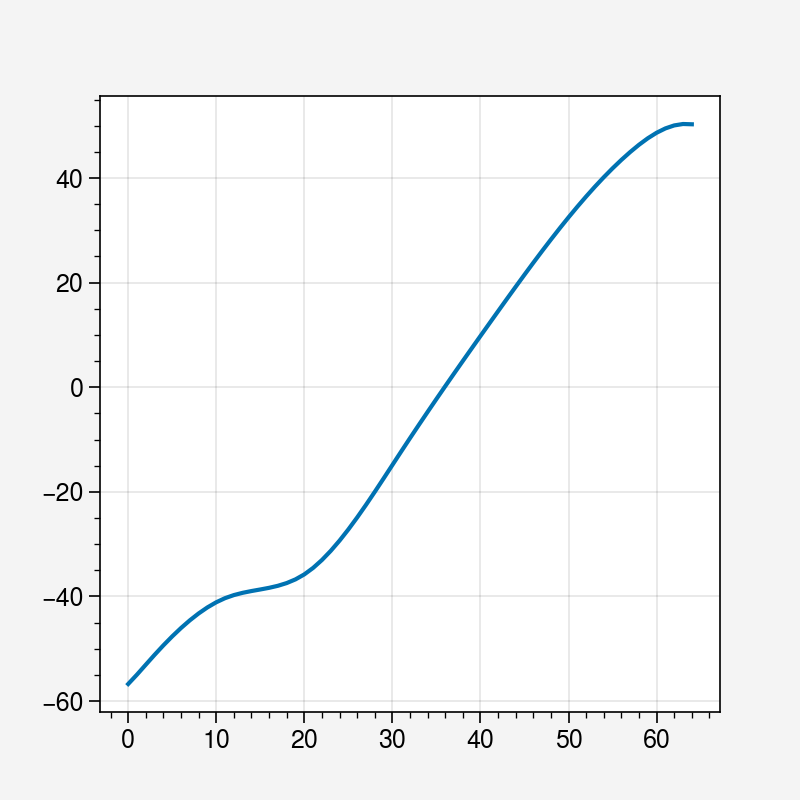

In [9]:
plt.figure()
plt.plot(signal_slp)
plt.figure()
plt.plot(imf[:,0])
plt.figure()
plt.plot(imf[:,1])
plt.figure()
plt.plot(imf[:,2])
plt.figure()
plt.plot(imf[:,3])

In [10]:
IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'nht')

Text(0.5, 0, 'Frequency (year^-1)')

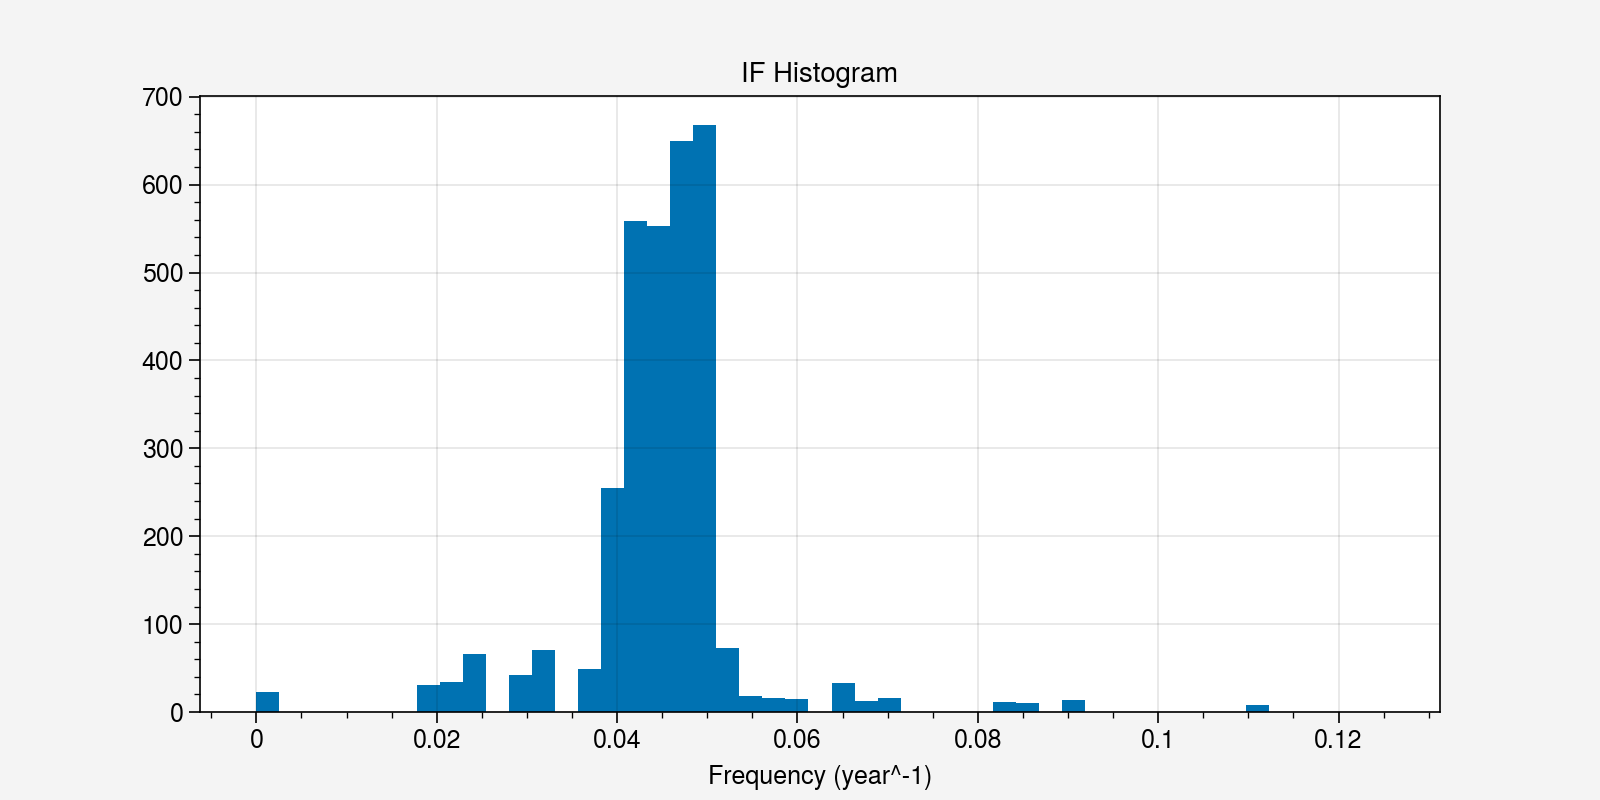

In [11]:
plt.figure(figsize=(8, 4))

# plt.subplot(121)
# Plot a simple histogram using frequency bins from 0-20Hz
plt.hist(IF[:, 2], np.linspace(0, .125), weights=IA[:, 2])
plt.grid(True)
plt.title('IF Histogram')
# plt.xticks(np.arange(0, 20, 5))
plt.xlabel('Frequency (year^-1)')

In [12]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, .5, 128, 'linear')

# Amplitude weighted HHT per IMF
f, spec_weighted = emd.spectra.hilberthuang(IF, IA, freq_edges, sum_imfs=False)

# Unweighted HHT per IMF - we replace the instantaneous amplitude values with ones
f, spec_unweighted = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, sum_imfs=False)

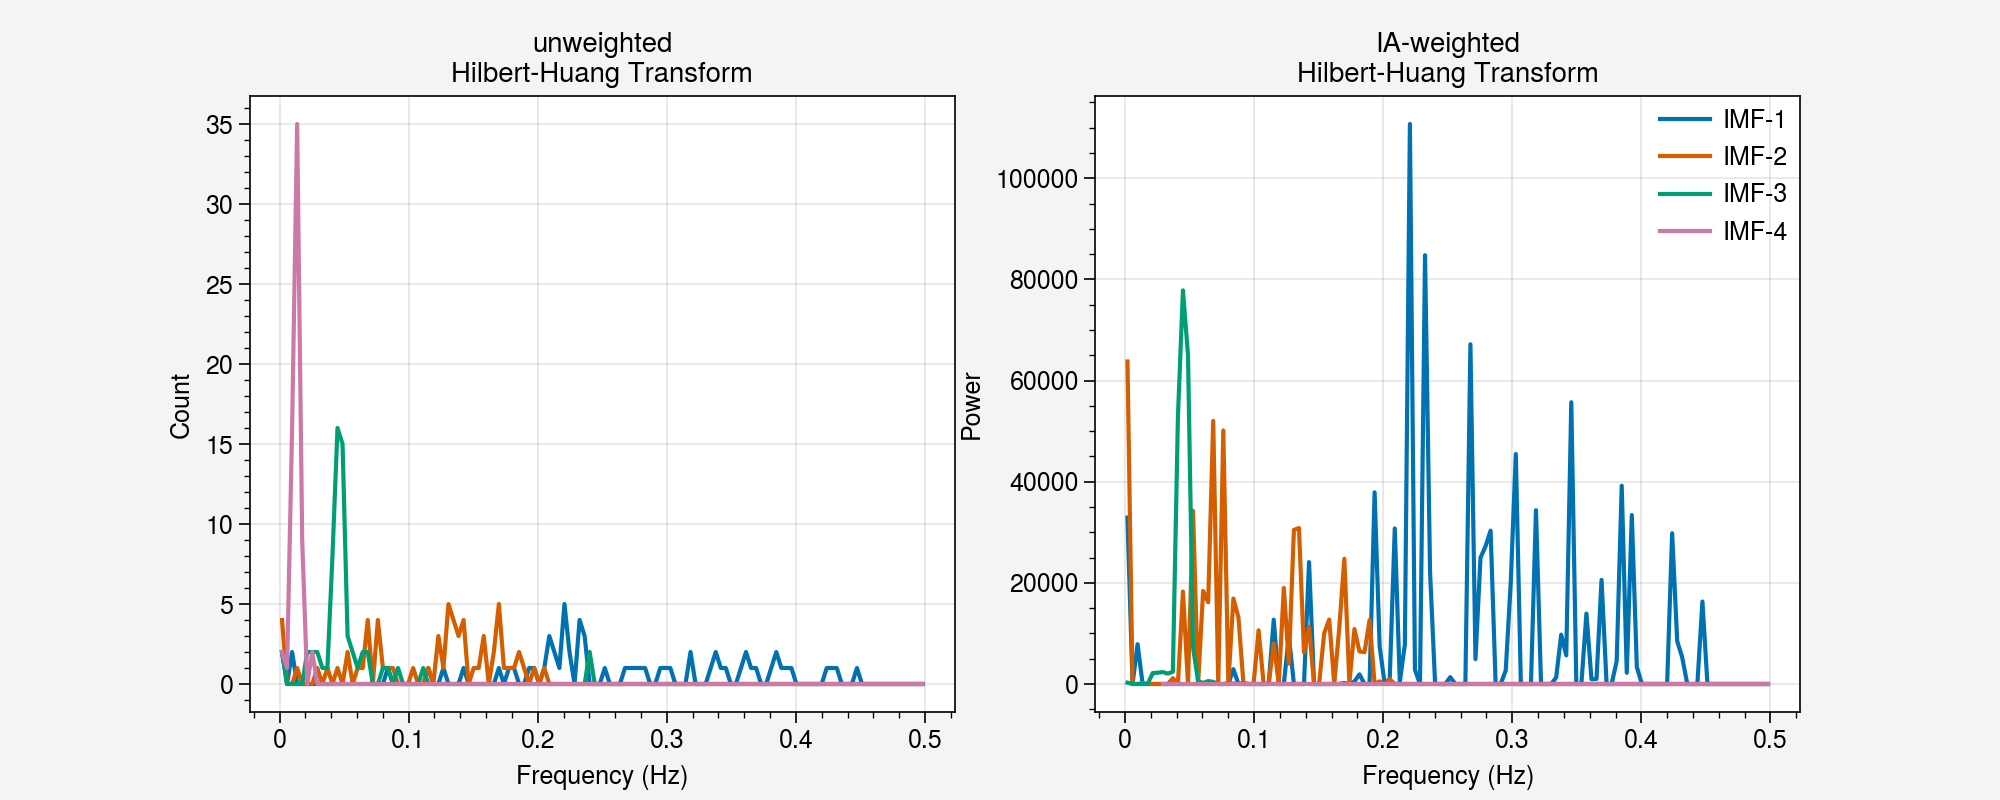

In [13]:
plt.figure(figsize=(10, 4))
plt.subplots_adjust(hspace=0.4)
plt.subplot(121)
plt.plot(freq_centres, spec_unweighted)
# plt.xticks(np.arange(10)*10)
# plt.xlim(0, 100)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.title('unweighted\nHilbert-Huang Transform')

plt.subplot(122)
plt.plot(freq_centres, spec_weighted)
# plt.xticks(np.arange(10)*10)
# plt.xlim(0, 100)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('IA-weighted\nHilbert-Huang Transform')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5'], frameon=False)

In [14]:
model.fit(slp_ann, dim='year')

In [15]:
rot_var = xeofs.single.EOFRotator(n_modes=20, power=1)
rot_var.fit(model)

In [16]:
# model.explained_variance_ratio()
components = rot_var.components()

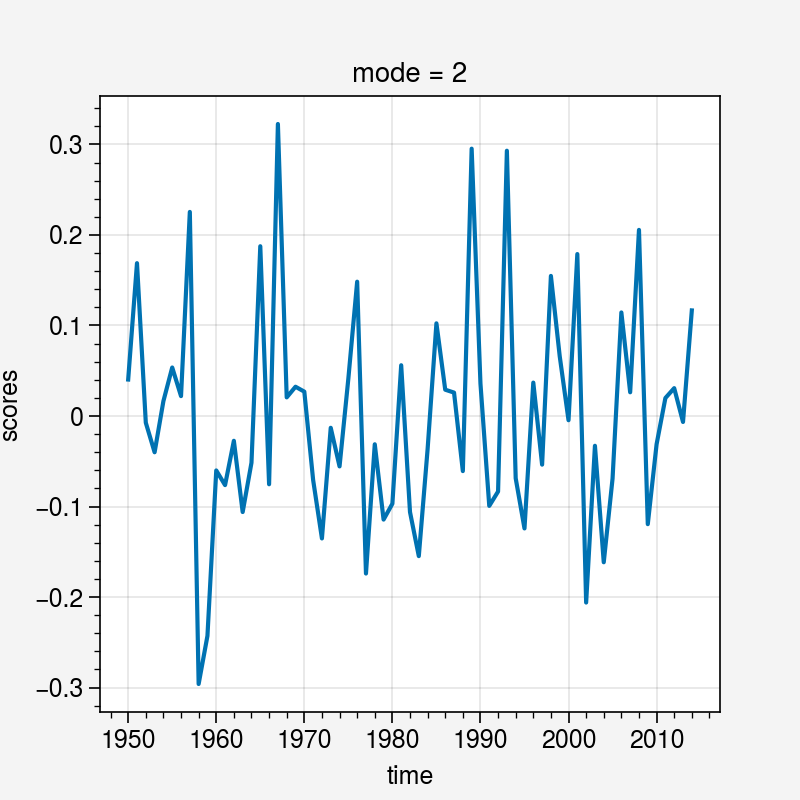

In [17]:
rot_var.scores(normalized=True).sel(mode=2).plot()

/projects/NS9873K/owul/conda/envs/ntc_pred/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


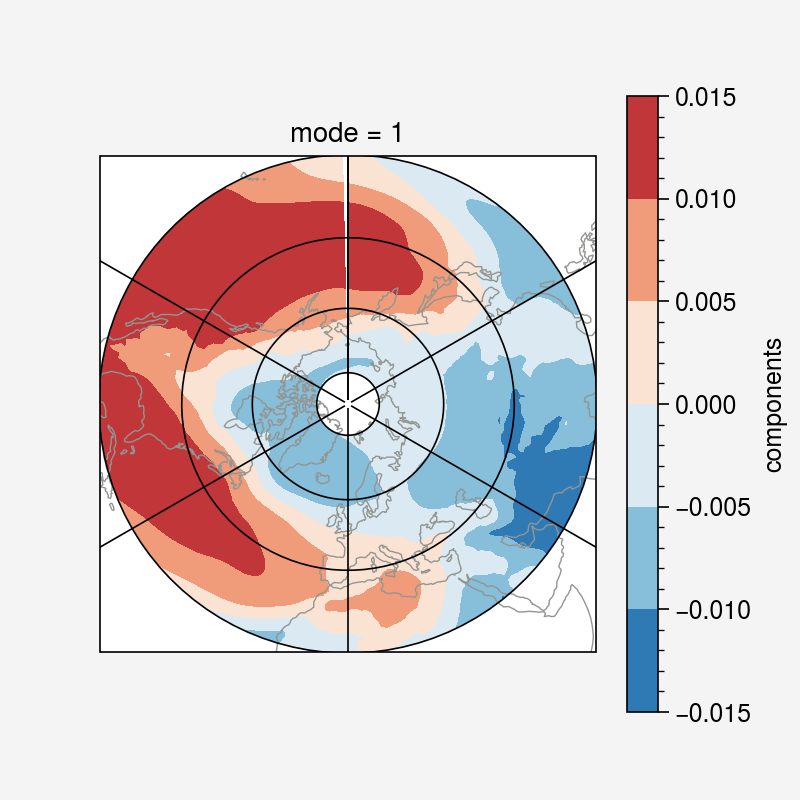

In [21]:
p = model.components().sel(mode=1).plot.contourf(subplot_kws=dict(projection=ccrs.NorthPolarStereo(), facecolor="white"),linewidths=2,transform=ccrs.PlateCarree())
p.axes.gridlines()
p.axes.coastlines(lw=.5,color='grey')

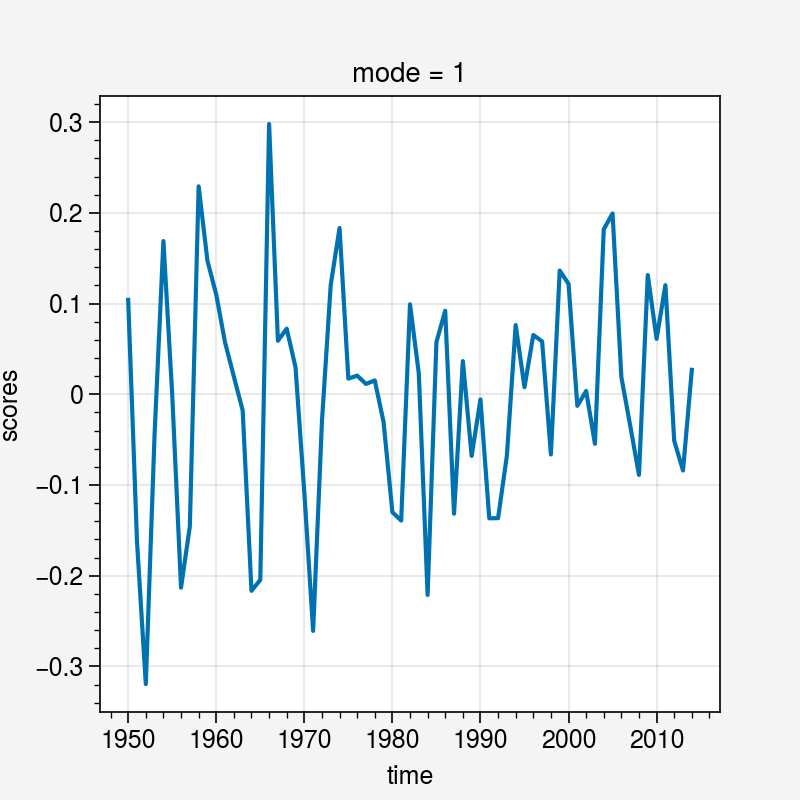

In [22]:
model.scores(normalized=True).sel(mode=1).plot()
# rot_var.scores(normalized=True).sel(mode=1).plot()

Compute the reference NAO from ERA5

In [23]:
era_mon = Path('/projects/NS9873K/DATA/SFE/ERA5/res_monthly_1/mean_sea_level_pressure')
e5lst = sorted([em for em in era_mon.glob('*.nc') if 1949 < int(em.stem.split('_')[-2]) < 2015])

In [24]:
ds_e5 = xr.open_mfdataset(e5lst)

In [25]:
e5_ann = ds_e5.sel(latitude=slice(90,20)).groupby(ds_e5.time.dt.year).mean().msl.compute()

In [26]:
e5_mon_deseas = ds_e5.sel(latitude=slice(90,20)).groupby(ds_e5.time.dt.month) - ds_e5.sel(latitude=slice(90,20)).groupby(ds_e5.time.dt.month).mean()

In [27]:
model_e5 = xeofs.single.EOF(n_modes=50, standardize=True,use_coslat=True)

/projects/NS9873K/owul/conda/envs/ntc_pred/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


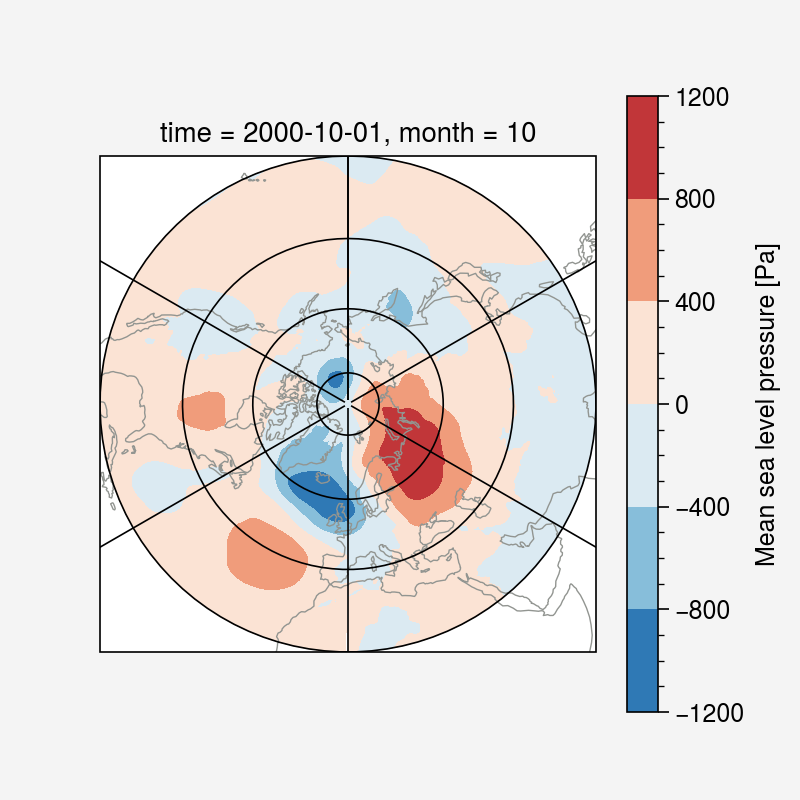

In [28]:
p1 = e5_mon_deseas.sel(latitude=slice(90,20),time='2000-10').msl.squeeze().plot.contourf(subplot_kws=dict(projection=ccrs.NorthPolarStereo(), facecolor="white"),linewidths=2,transform=ccrs.PlateCarree())
p1.axes.gridlines()
p1.axes.coastlines(lw=.5,color='grey')

In [29]:
model_e5.fit(e5_mon_deseas.sel(latitude=slice(90,20)).msl.compute(), dim='time')

In [30]:
model_e5.explained_variance_ratio()

<xarray.DataArray 'explained_variance_ratio' (mode: 50)>
array([0.14199672, 0.09255257, 0.07337604, 0.0690982 , 0.04660708,
       0.04596481, 0.0435404 , 0.04124645, 0.03910725, 0.03287934,
       0.02794886, 0.02362934, 0.02084854, 0.01978546, 0.01946692,
       0.01523086, 0.01369832, 0.01343107, 0.01196445, 0.01116868,
       0.01063517, 0.0098532 , 0.00950897, 0.00921888, 0.00827762,
       0.00797156, 0.00718892, 0.00649897, 0.00597226, 0.00559074,
       0.00506199, 0.00457686, 0.00449837, 0.00392115, 0.00387065,
       0.00348187, 0.00328913, 0.0031038 , 0.00294293, 0.00286388,
       0.002603  , 0.00245432, 0.00238397, 0.00227324, 0.00218139,
       0.00201418, 0.00189328, 0.0018473 , 0.00180273, 0.00176227])
Coordinates:
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10 ... 41 42 43 44 45 46 47 48 49 50
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.2
    date:           2024-10-03 11:19:03
    n_modes:        50
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

/projects/NS9873K/owul/conda/envs/ntc_pred/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


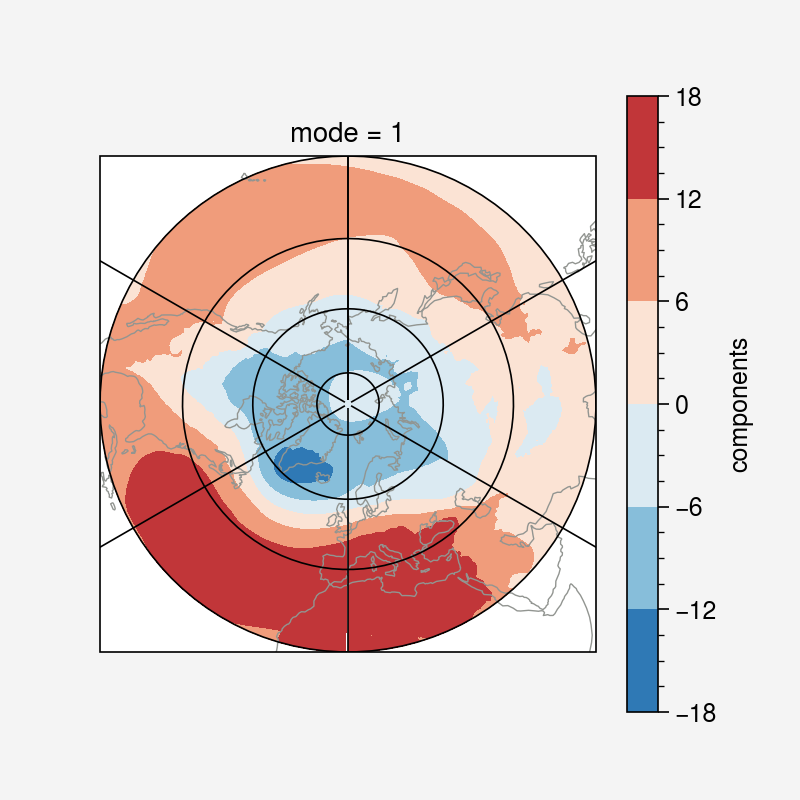

In [31]:
p = model_e5.components(normalized=False).sel(mode=1).plot.contourf(subplot_kws=dict(projection=ccrs.NorthPolarStereo(), facecolor="white"),linewidths=2,transform=ccrs.PlateCarree())
p.axes.gridlines()
p.axes.coastlines(lw=.5,color='grey')

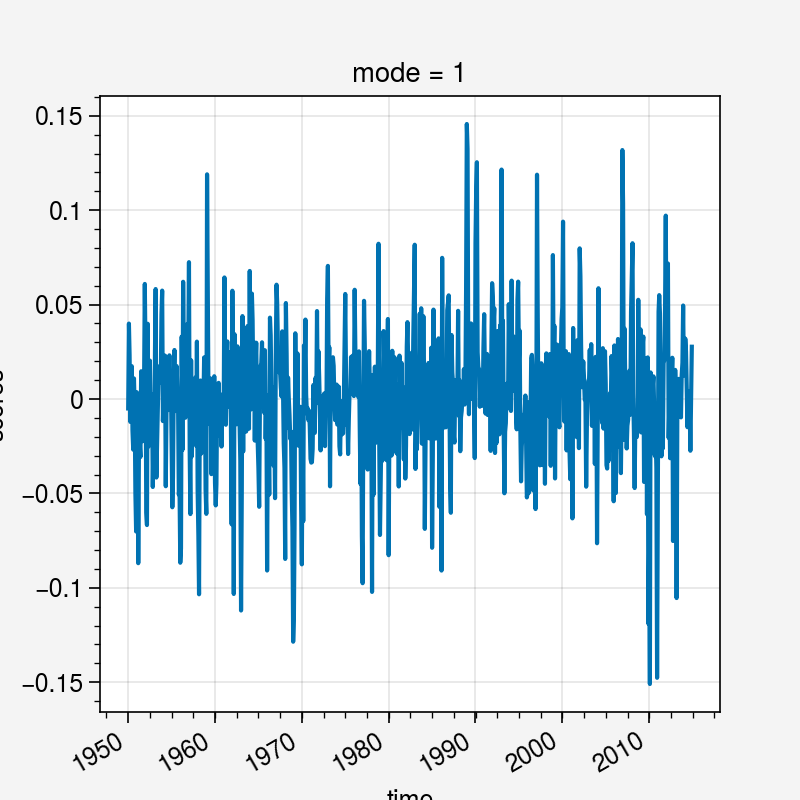

In [32]:
model_e5.scores(normalized=True).sel(mode=1).plot()

In [33]:
signal_nao_e5 = model_e5.scores(normalized=True).sel(mode=2).values

In [34]:
imf_nao_e5 = emd.sift.sift(signal_nao_e5)

In [35]:
print(imf_nao_e5.var(0)/signal_nao_e5.var())
print((imf_nao_e5.var(0)/signal_nao_e5.var()).sum())

[0.62103335 0.18466457 0.10303728 0.12317842 0.02255922 0.01456481
 0.05596744]
1.125005086574472


In [36]:
1/.02

50.0

Text(0, 0.5, 'Power')

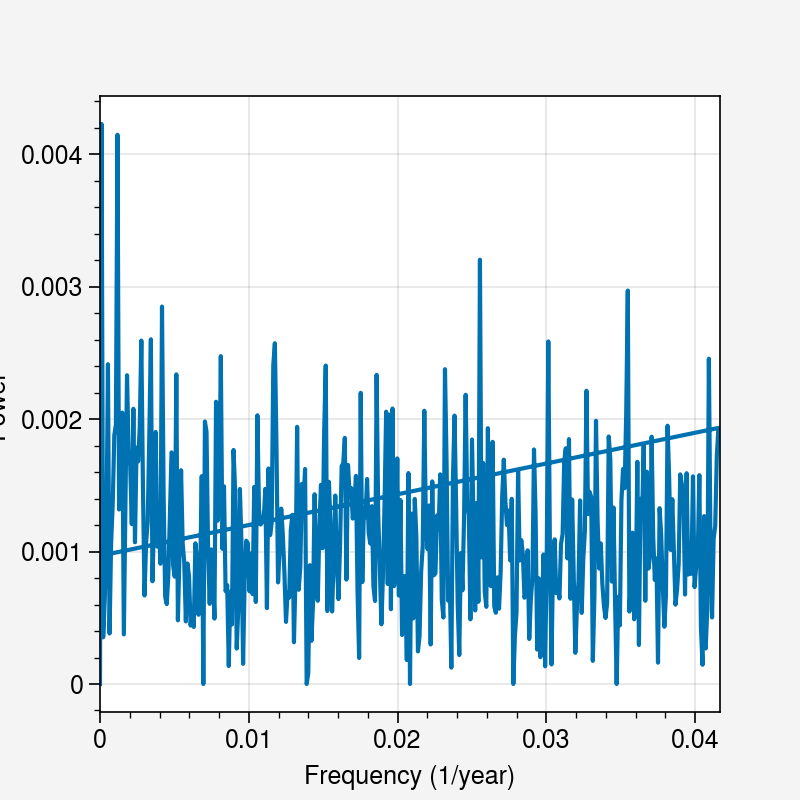

In [37]:
pxx = np.fft.fft(signal_nao_e5) / len(signal_nao_e5)
fft_f = np.fft.fftfreq(signal_nao_e5.shape[0], d=12)

plt.figure()
plt.plot(fft_f, np.abs(pxx))
plt.xlim(0, .5/12)
plt.xlabel('Frequency (1/year)')
plt.ylabel('Power')

In [39]:
np.corrcoef(imf_nao_e5[:,0],imf_nao_e5[:,1])[0,1]

-0.028965718139750695

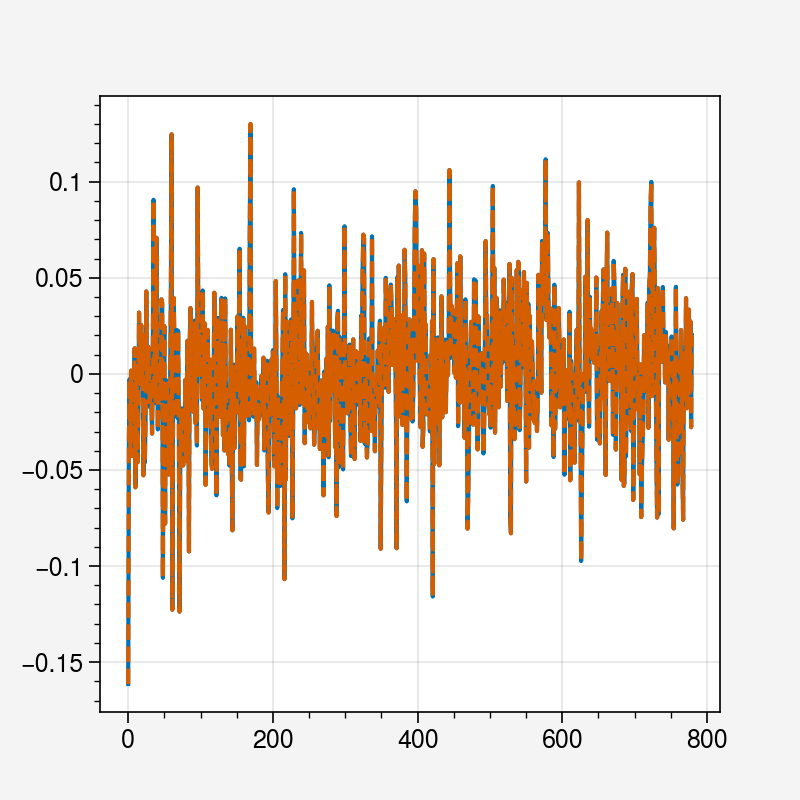

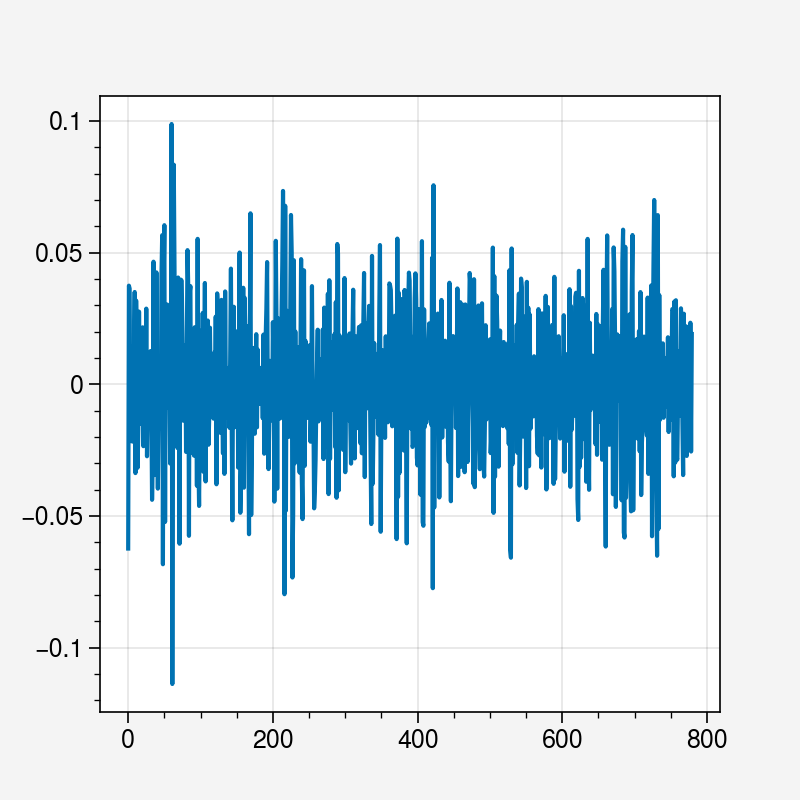

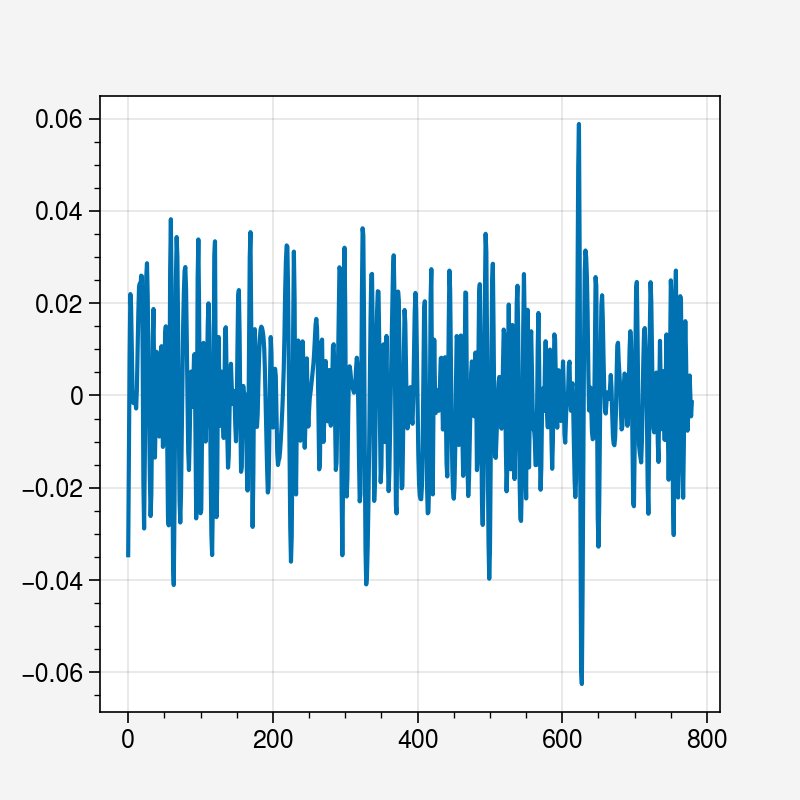

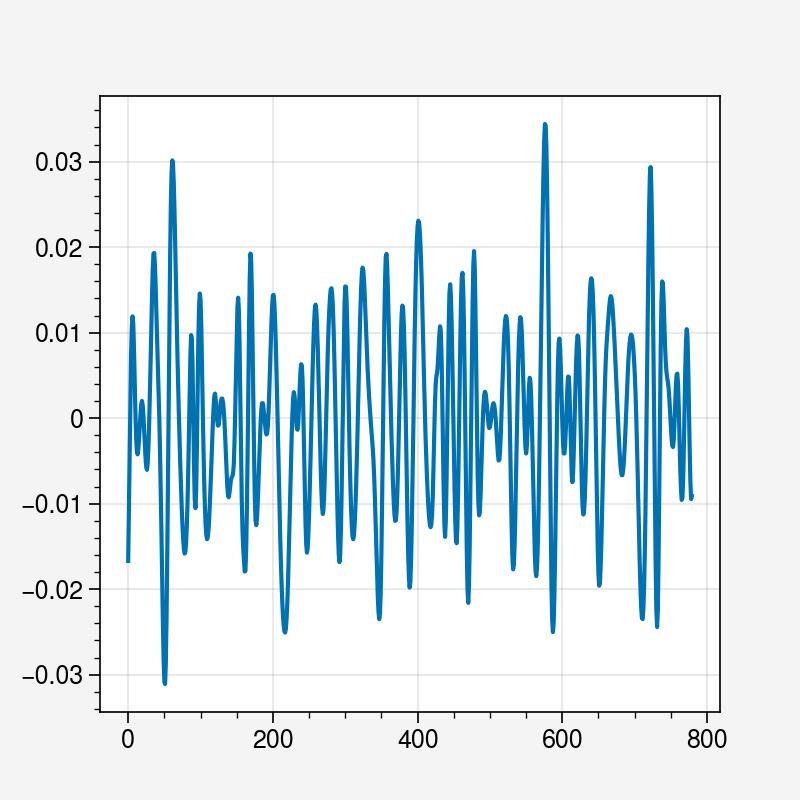

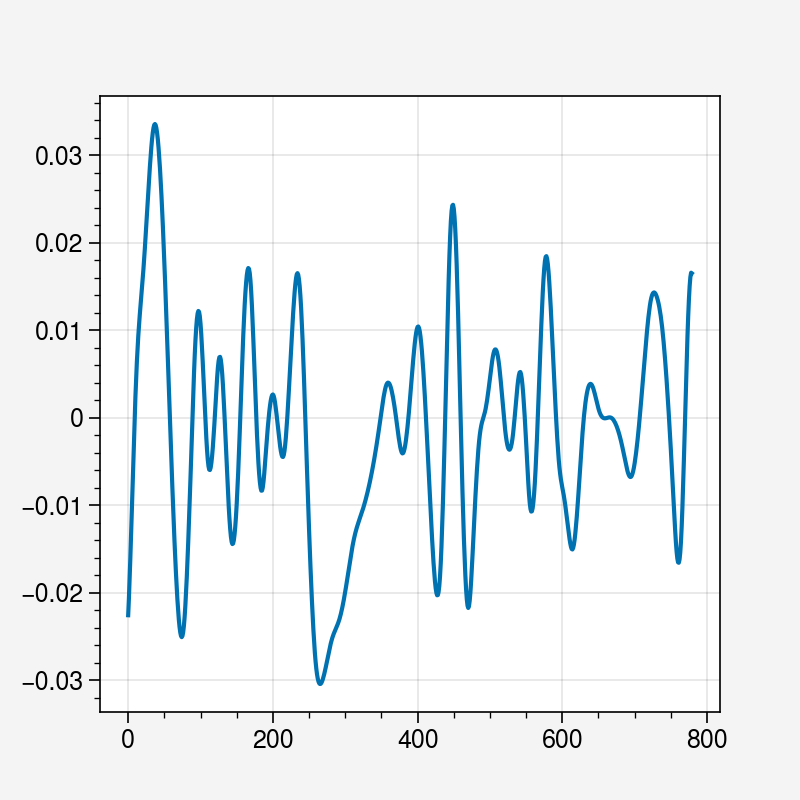

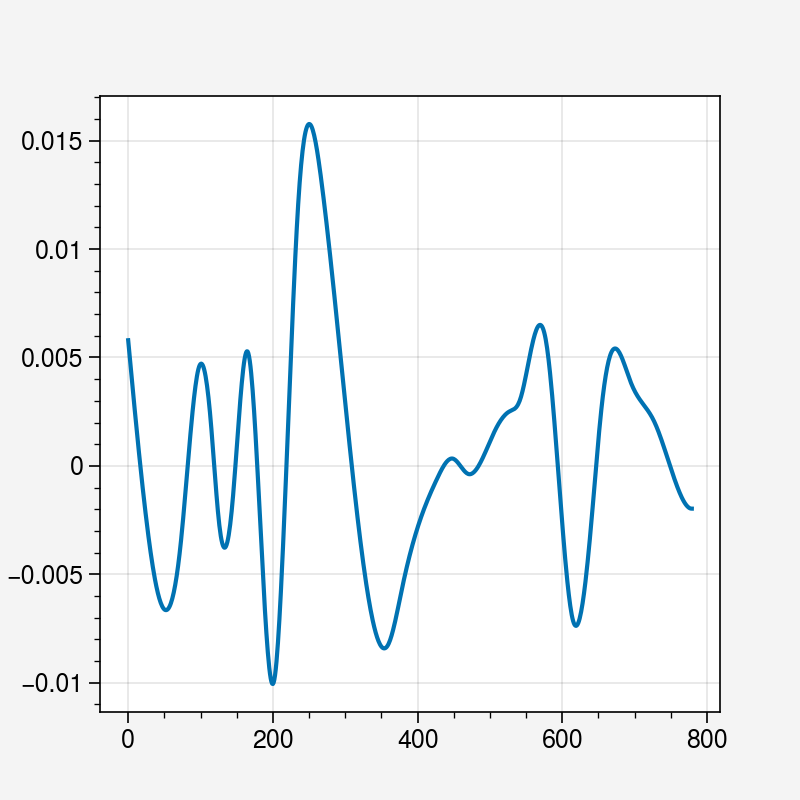

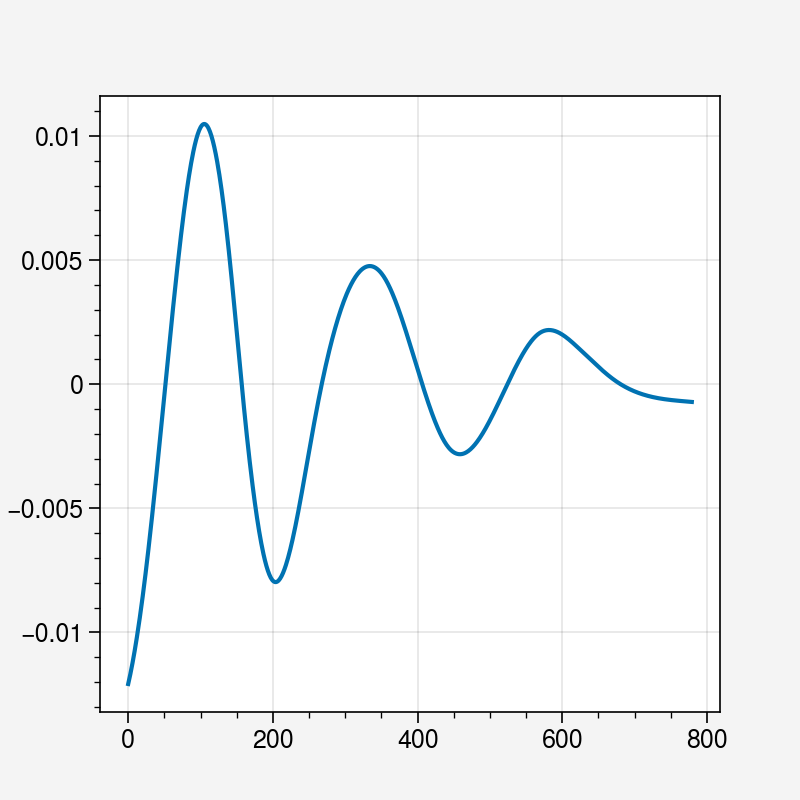

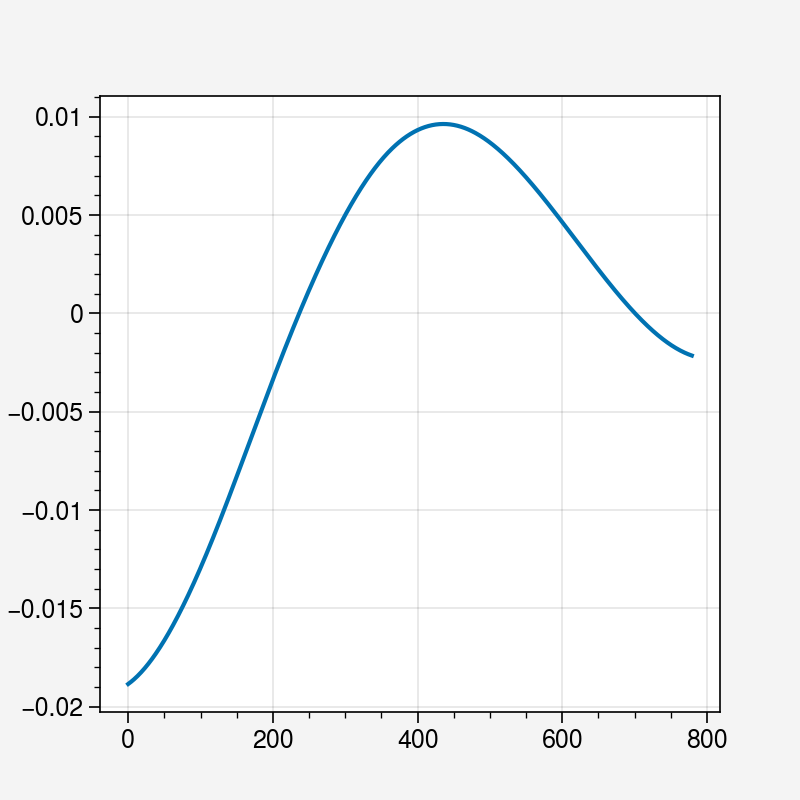

In [40]:
plt.figure()
plt.plot(signal_nao_e5)
plt.plot(imf_nao_e5.sum(1),ls='dashed')
plt.figure()
plt.plot(imf_nao_e5[:,0])
plt.figure()
plt.plot(imf_nao_e5[:,1])
plt.figure()
plt.plot(imf_nao_e5[:,2])
plt.figure()
plt.plot(imf_nao_e5[:,3])
plt.figure()
plt.plot(imf_nao_e5[:,4])
plt.figure()
plt.plot(imf_nao_e5[:,5])
plt.figure()
plt.plot(imf_nao_e5[:,6])

In [56]:
IP, IF, IA = emd.spectra.frequency_transform(imf_nao_e5, 1, 'nht')
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, .125, 128, 'linear')

# Amplitude weighted HHT per IMF
f, spec_weighted = emd.spectra.hilberthuang(IF, IA, freq_edges, sum_imfs=False)

# Unweighted HHT per IMF - we replace the instantaneous amplitude values with ones
f, spec_unweighted = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, sum_imfs=False)


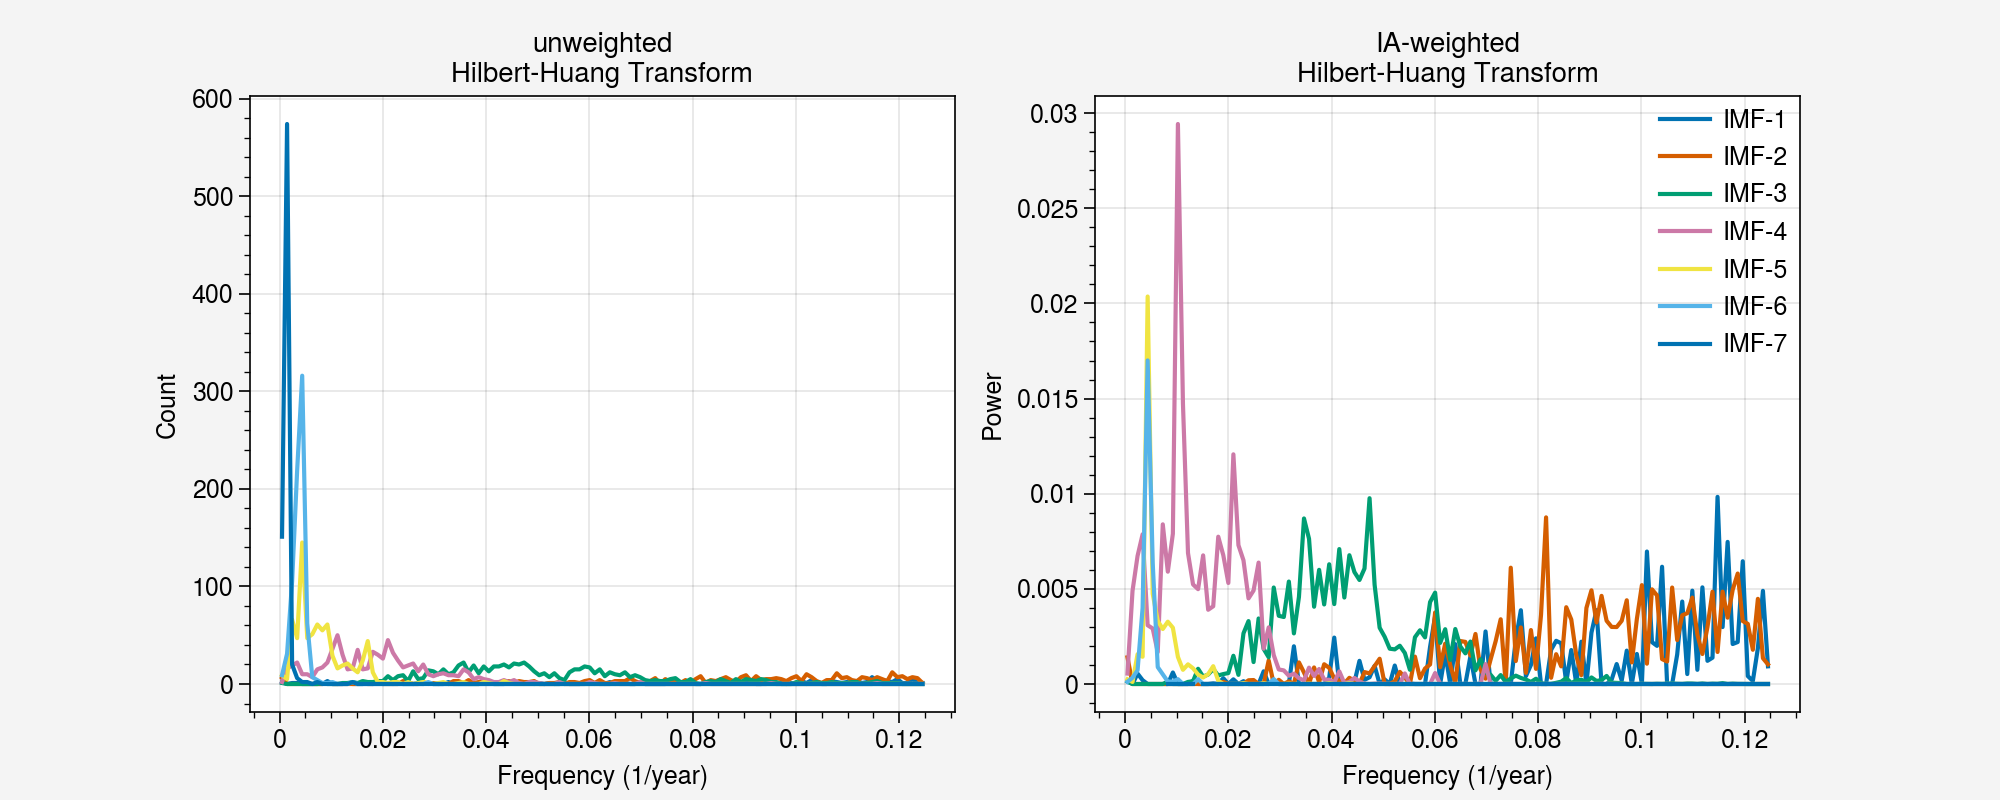

In [57]:
plt.figure(figsize=(10, 4))
plt.subplots_adjust(hspace=0.4)
plt.subplot(121)
plt.plot(freq_centres, spec_unweighted)
# plt.xticks(np.arange(10)*10)
# plt.xlim(0, 100)
plt.xlabel('Frequency (1/year)')
plt.ylabel('Count')
plt.title('unweighted\nHilbert-Huang Transform')

plt.subplot(122)
plt.plot(freq_centres, spec_weighted)
# plt.xticks(np.arange(10)*10)
# plt.xlim(0, 100)
plt.xlabel('Frequency (1/year)')
plt.ylabel('Power')
plt.title('IA-weighted\nHilbert-Huang Transform')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5', 'IMF-6', 'IMF-7'], frameon=False)

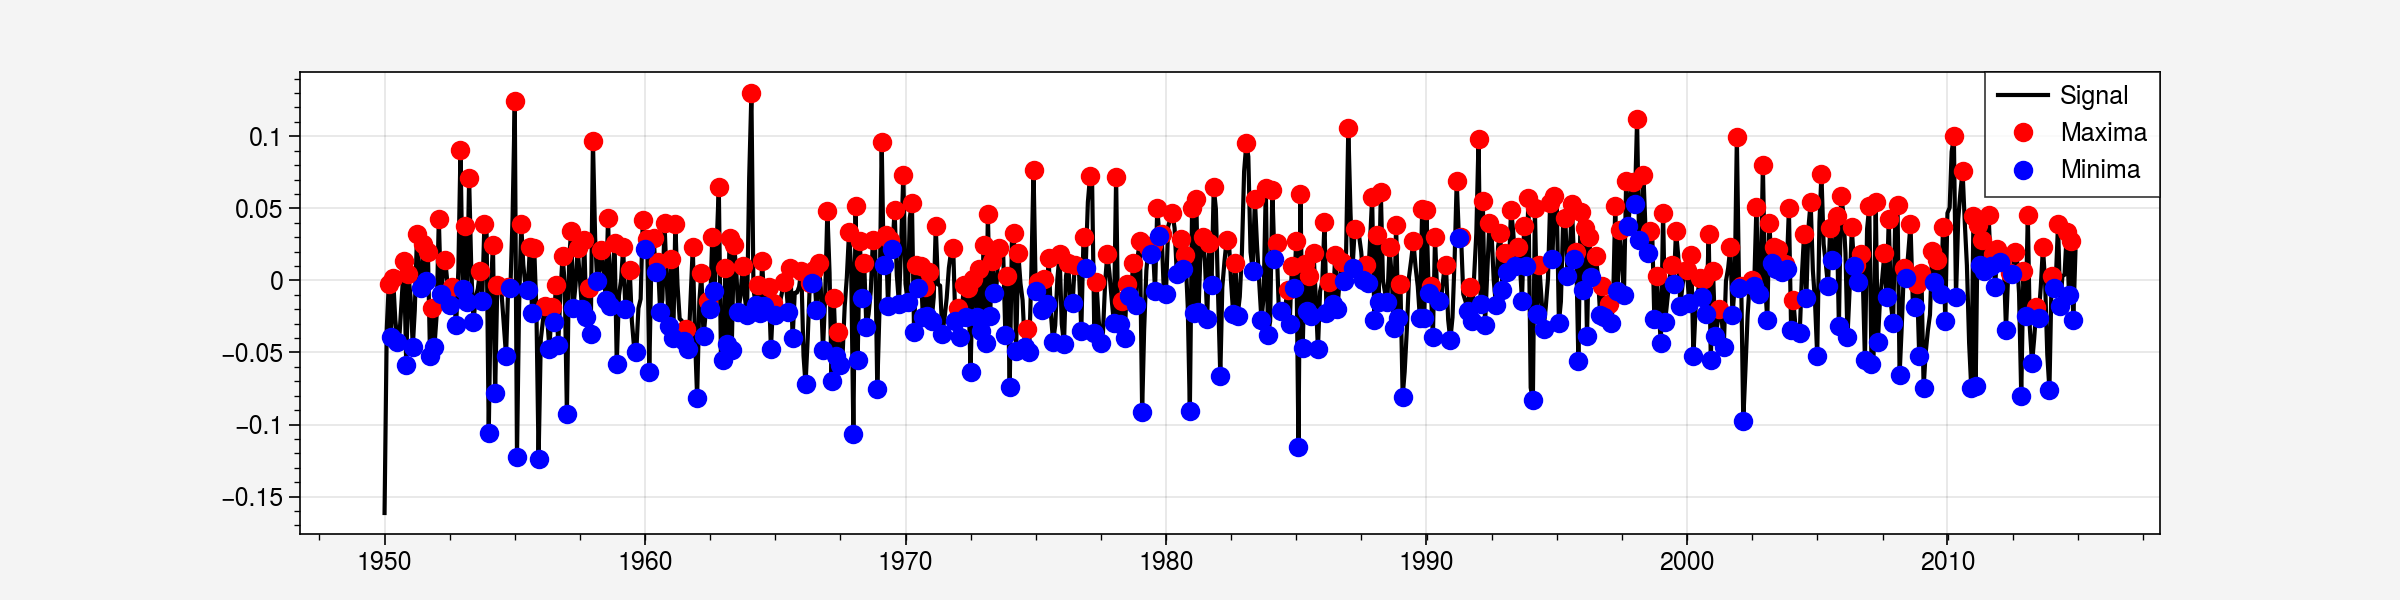

In [53]:
max_locs, max_mag = emd.sift.get_padded_extrema(signal_nao_e5 , pad_width=0, mode='peaks')
min_locs, min_mag = emd.sift.get_padded_extrema(signal_nao_e5, pad_width=0, mode='troughs')

plt.figure(figsize=(12, 3))
plt.plot(e5_mon_deseas.time,signal_nao_e5, 'k')
plt.plot(e5_mon_deseas.time.values[max_locs], max_mag, 'or')
plt.plot(e5_mon_deseas.time.values[min_locs], min_mag, 'ob')
# plt.plot(signal_nao_e5, 'k')
# plt.plot(max_locs,max_mag, 'or')
# plt.plot(min_locs,min_mag, 'ob')
plt.legend(['Signal', 'Maxima', 'Minima'])

For an idea of each model's suitability, make figures:

1) EOF1 & 2 (20N - 90N) patterns of monthly mean SLP (seasonal cycle removed via long-term by-month average) for ERA5 (reference) and all models incl. share of explained variance
2) PC1 & 2 time series for all (do they *look* similar?)
3) spectra for ERA5 & all models (in *one* plot?)
4) low-pass filtered NAO time series unshifted and shifted
5) project wind onto NAO

Steps:
1) Compute and save EOF1 & 2, PC1 & 2 for ERA5 and each model
2) Compute and save spectra
3) low-pass filter NAO time series and